In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/e14/txs156/Analysis/ACCESS-OM2/Clustering/ASC_and_heat_transport/Figures/'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34107,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:36255,Total threads: 4
Dashboard: /proxy/39333/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:40939,


In [4]:
master_session = cc.database.create_session()

#1/10th-degree
control_01 = '01deg_jra55v13_ryf9091'

# We choose the 1/10th degree experiment
expt = control_01

# Average over the final 10 years of the run
no_yrs = 10

lat_slice  = slice(-90,-59)
time_slice = slice(-12*no_yrs, None)

In [5]:
# Obtain bottom topography
ht = cc.querying.getvar(expt,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
# Obtain surface area
area_t = cc.querying.getvar(expt,'area_t' , master_session,n=1).sel(yt_ocean=lat_slice)

In [6]:
%%time
# Load the zonal velocity
u_con = cc.querying.getvar(expt, 'u', master_session, frequency='1 monthly') 
u_con_surf = u_con.sel(yu_ocean=lat_slice).isel(time=time_slice, st_ocean=0)
u_con_surf = u_con_surf.mean('time').load()

# Load the meridional velocity
v_con = cc.querying.getvar(expt, 'v', master_session, frequency='1 monthly') 
v_con_surf = v_con.sel(yu_ocean=lat_slice).isel(time=time_slice, st_ocean=0)
v_con_surf = v_con_surf.mean('time').load()

# Load the surface temp
temp_con = cc.querying.getvar(expt, 'temp', master_session, frequency='1 monthly')-273.15
temp_con_surf = temp_con.sel(yu_ocean=lat_slice).isel(time=time_slice, st_ocean=0)
temp_con_surf = temp_con_surf.mean('time').load()

# Load the surface salinity
salt_con = cc.querying.getvar(expt, 'salt', master_session, frequency='1 monthly') 
salt_con_surf = salt_con.sel(yu_ocean=lat_slice).isel(time=time_slice, st_ocean=0)
salt_con_surf = salt_con_surf.mean('time').load()

KeyError: "'yu_ocean' is not a valid dimension or coordinate"

In [7]:
speed = (u_con_surf**2+v_con_surf**2)**0.5

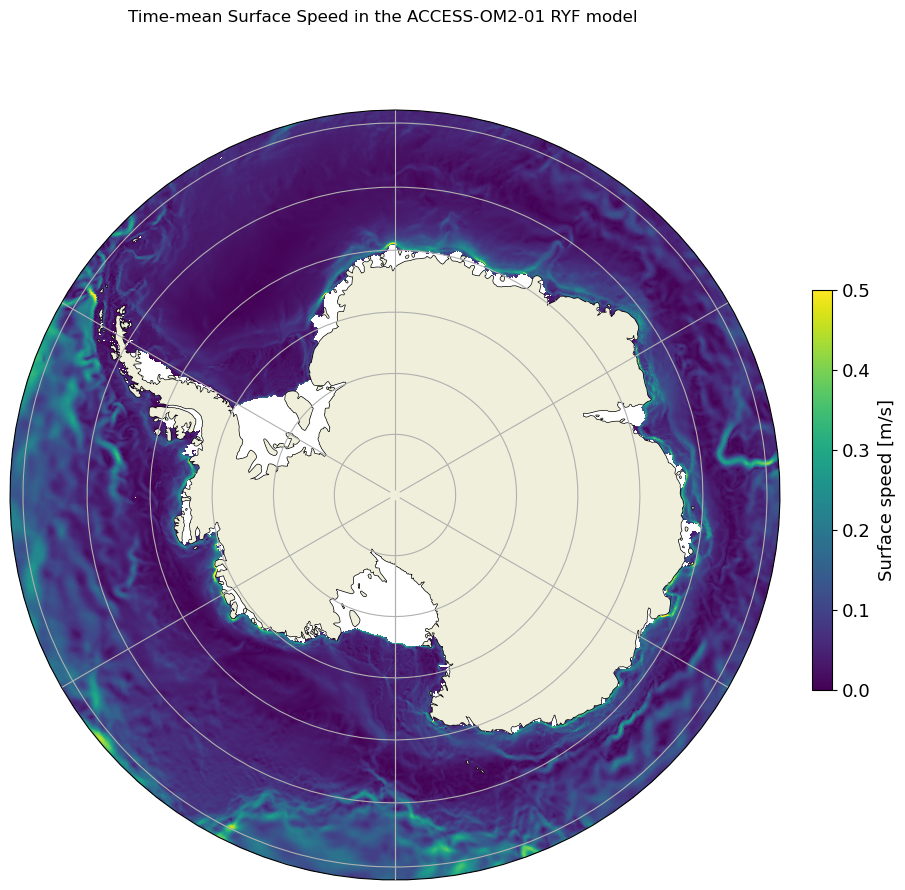

CPU times: user 8.98 s, sys: 764 ms, total: 9.74 s
Wall time: 8.95 s


In [8]:
%%time

plateCr = ccrs.SouthPolarStereo()
plateCr._threshold = plateCr._threshold/100.  #set finer threshold

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
# Create colormap with specified colors for specific values
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), subplot_kw={'projection': plateCr})

t1 = speed.plot(ax=axs, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap=plt.cm.viridis, add_colorbar=False)
axs.coastlines();
axs.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
axs.set_boundary(circle, transform=axs.transAxes)

gl = axs.gridlines(draw_labels=False, xlocs=None, ylocs=None, zorder=10001)
gl.n_steps = 90
axs.add_feature(cfeature.LAND, zorder=1000)

cbaxes = fig.add_axes([0.93, 0.3, 0.02, 0.4])
cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'vertical')
cbar.set_label(r'Surface speed [m/s]', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
axs.set_title('')

plt.suptitle('Time-mean Surface Speed in the ACCESS-OM2-01 RYF model')
plt.savefig(figdir+'mean_speed_ASC.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
speed_1d = speed.stack(z = ['yu_ocean', 'xu_ocean'])
speed_1d_masked = speed_1d.dropna(dim='z')

XX,YY = np.meshgrid(speed.xu_ocean.values, speed.yu_ocean.values)
xu_masked = XX.flatten()*speed_1d/speed_1d
yu_masked = YY.flatten()*speed_1d/speed_1d

In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

n_clusters = []
labels_gmm = []
centers_gmm = []
probs_gmm = []

aic_gmm = []
bic_gmm = []
silhouette_gmm = []

X = speed_1d_masked.values.reshape(-1,1)

k_clusters = range(1,22)
for k in tqdm(k_clusters):
    n_clusters.append(k)
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels_gmm.append(gmm.fit_predict(X))
    # centers_gmm.append(gmm.means_)
    # probs_gmm.append(gmm.predict_proba(X))
    # aic_gmm.append(gmm.aic(X))
    bic_gmm.append(gmm.bic(X))


100%|██████████| 21/21 [02:44<00:00,  7.83s/it]


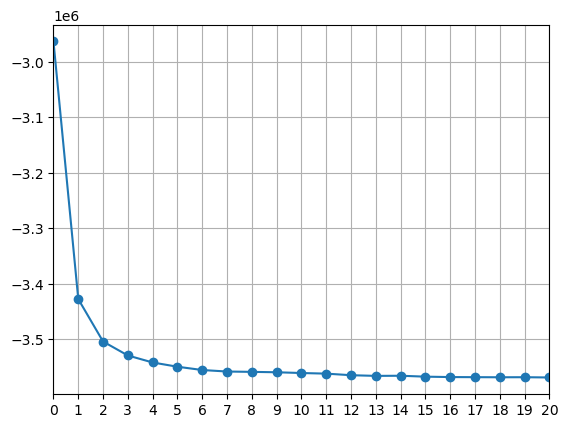

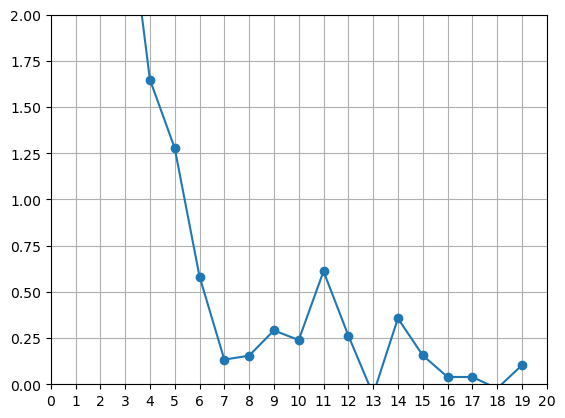

In [11]:
plt.plot(bic_gmm, '-o')
plt.gca().set_xticks(np.arange(0,21))
plt.xlim(0,20)
plt.grid()
plt.show()
plt.plot(np.diff(bic_gmm)/np.diff(bic_gmm)[0]*100, '-o')
plt.ylim(0,2)
plt.gca().set_xticks(np.arange(0,21))
plt.xlim(0,20)

plt.grid()


In [39]:
labels_full = []

a = np.array(xu_masked)
b = np.array(a[~np.isnan(a)])

b_rounded = np.round(b, decimals=2)
a_rounded = np.round(a, decimals=2)

# Create an array of NaN values with the same shape as `a`
matching_indices = np.where(np.isin(a_rounded, b_rounded))[0]

for n_optimal in tqdm(range(21)):
    labels_nanned = np.full_like(a, np.nan)
    labels_nanned[matching_indices] = labels_gmm[n_optimal]
    labels_full.append(labels_nanned)

labels_3D =  np.array(labels_full).reshape(21,510,3600)
labels_3D_da = xr.DataArray(data=labels_3D, dims = ['cluster',  'yu_ocean', 'xu_ocean'], coords = {'cluster':np.arange(0,21), 'xu_ocean': speed.xu_ocean.values, 'yu_ocean': speed.yu_ocean.values})

100%|██████████| 21/21 [00:00<00:00, 231.58it/s]


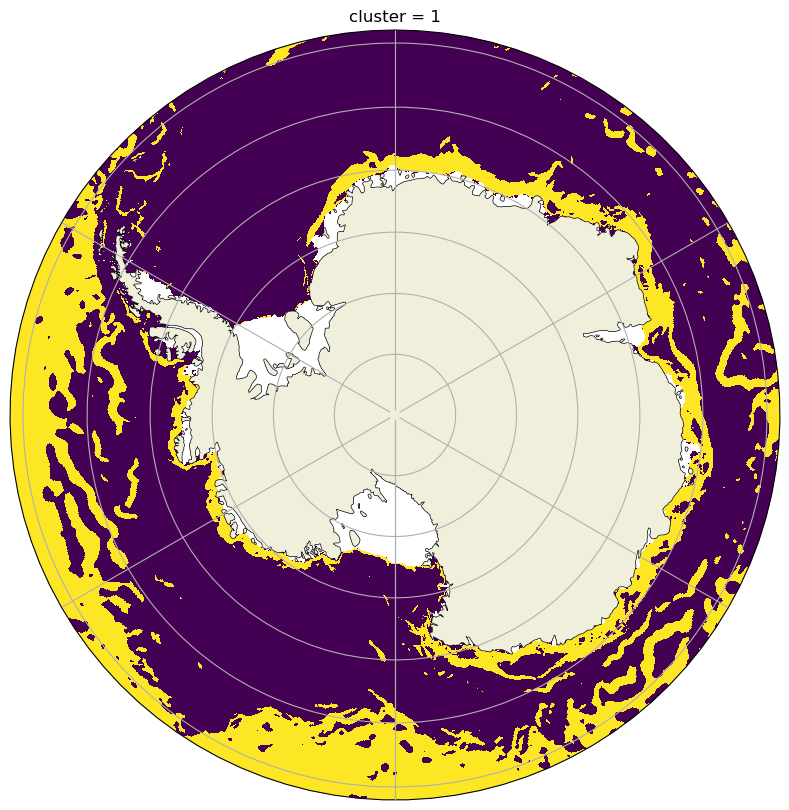

CPU times: user 2.87 s, sys: 67.1 ms, total: 2.94 s
Wall time: 2.86 s


In [41]:
%%time

plateCr = ccrs.SouthPolarStereo()
plateCr._threshold = plateCr._threshold/100.  #set finer threshold

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
    
# Create colormap with specified colors for specific values
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), subplot_kw={'projection': plateCr})

t1 = labels_3D_da.isel(cluster=1).plot(ax=axs, transform=ccrs.PlateCarree(), vmin=0, vmax=0.5, cmap=plt.cm.viridis, add_colorbar=False)

# labels_3D_da.isle(cluster=0).plot(axs.pcolor(speed.xu_ocean.values, speed.yu_ocean.values, labels_3D[1,:,:], cmap=plt.cm.viridis, transform=ccrs.PlateCarree())
axs.coastlines();
axs.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
axs.set_boundary(circle, transform=axs.transAxes)

gl = axs.gridlines(draw_labels=False, xlocs=None, ylocs=None, zorder=10001)
gl.n_steps = 90
axs.add_feature(cfeature.LAND, zorder=1000)

# cbaxes = fig.add_axes([0.93, 0.3, 0.02, 0.4])
# cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'vertical')
# cbar.set_label(r'Surface speed [m/s]', fontsize=13, labelpad=5)
# cbar.ax.tick_params(labelsize=13)
# axs.set_title('')

# plt.suptitle('Time-mean Surface Speed in the ACCESS-OM2-01 RYF model')
# plt.savefig(figdir+'mean_speed_ASC.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


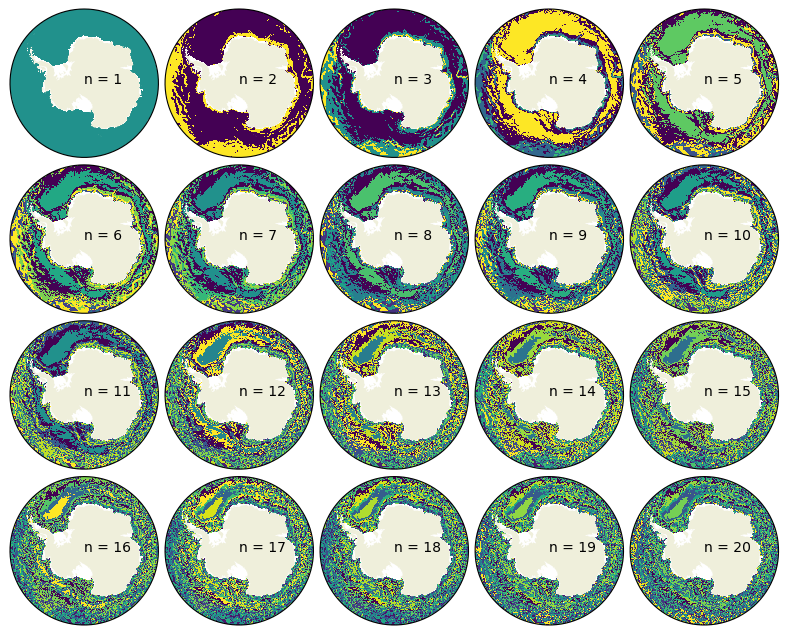

CPU times: user 1min 37s, sys: 1.06 s, total: 1min 38s
Wall time: 1min 36s


In [74]:
%%time
plateCr = ccrs.SouthPolarStereo()
plateCr._threshold = plateCr._threshold/100.  #set finer threshold

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(12.5*0.8,10*0.8), subplot_kw={'projection': plateCr})
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.05, wspace=0.001)
for i in tqdm(range(20)):
    axs[i].set_boundary(circle, transform=axs[i].transAxes)
    axs[i].set_extent([-180, 180, -90, -59], ccrs.PlateCarree())
    t1 = labels_3D_da.isel(cluster=i).plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap=plt.cm.viridis, add_colorbar=False)
    # gl = axs[i].gridlines(draw_labels=False, xlocs=None, ylocs=None, zorder=10001)
    # gl.n_steps = 90
    axs[i].add_feature(cfeature.LAND, zorder=1000)
    axs[i].set_title('')
    axs[i].annotate('n = '+str(i+1), (0,-90), transform=ccrs.PlateCarree(), zorder=1000000)
plt.savefig(figdir+'speed_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
temp_con_on = temp_con_both.temp.where(ht<depth_max).sel(st_ocean=slice(None,depth_max))
temp_con_off = temp_con_both.temp.where(ht>depth_max)

salt_con_on = salt_con_both.salt.where(ht<depth_max).sel(st_ocean=slice(None,depth_max))
salt_con_off = salt_con_both.salt.where(ht>depth_max)

area_t_on = area_t*(temp_con_on/temp_con_on).isel(st_ocean=0)
area_t_off = area_t*(temp_con_off/temp_con_off).isel(st_ocean=0)

In [9]:
depth_array = temp_con_both.temp * 0 + temp_con_both.temp.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con_both = temp_con_both.temp.where(depth_array.st_ocean >= max_depth)
bottom_temp_con_both = bottom_temp_con_both.sum(dim = 'st_ocean')

depth_array = salt_con_both.salt * 0 + salt_con_both.salt.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_con_both = salt_con_both.salt.where(depth_array.st_ocean >= max_depth)
bottom_salt_con_both = bottom_salt_con_both.sum(dim = 'st_ocean')

bottom_temp_con_both.load()
bottom_salt_con_both.load()

bottom_salt_con_both_nan = bottom_salt_con_both.where(bottom_salt_con_both != 0, np.nan)


In [10]:
LonsPts_pos = [0,0,5,10,20,75,80,80,0]
LatsPts_pos = [-90,-68,-66, -65, -63, -63, -63,-90, -90]

LonsPts_neg = [-280,-280,-265, -210,-180, -80,-70,-60,-52, -50,-40,-35, 0, 0,-280]
LatsPts_neg = [-90,-64, -62, -64, -67,-67, -63, -60,-60, -62.5,-65,-65,-68, -90,-90]


In [11]:
import math 
import matplotlib

x_pixel_nos = LonsPts_pos
y_pixel_nos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_nos, y_pixel_nos):
    temp_list.append([a, b])

polygon = np.array(temp_list)
left = np.min(polygon, axis=0)
right = np.max(polygon, axis=0)
x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
xv, yv = temp_con_off.xt_ocean.values, temp_con_off.yt_ocean.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)

x_pixel_nos = LonsPts_neg
y_pixel_nos = LatsPts_neg

temp_list = []
for a, b in zip(x_pixel_nos, y_pixel_nos):
    temp_list.append([a, b])

polygon = np.array(temp_list)
left = np.min(polygon, axis=0)
right = np.max(polygon, axis=0)
x = np.arange(math.ceil(left[0]), math.floor(right[0])+1)
y = np.arange(math.ceil(left[1]), math.floor(right[1])+1)
xv, yv = temp_con_off.xt_ocean.values, temp_con_off.yt_ocean.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_neg = mask*np.ones_like(lon2d)

mask_tot = mask_bit_pos+mask_bit_neg
mask_tot[mask_tot==0] = np.nan

In [12]:
lon_slice_dense = 70
lon_slice_fresh = -260
lon_slice_warm = -130

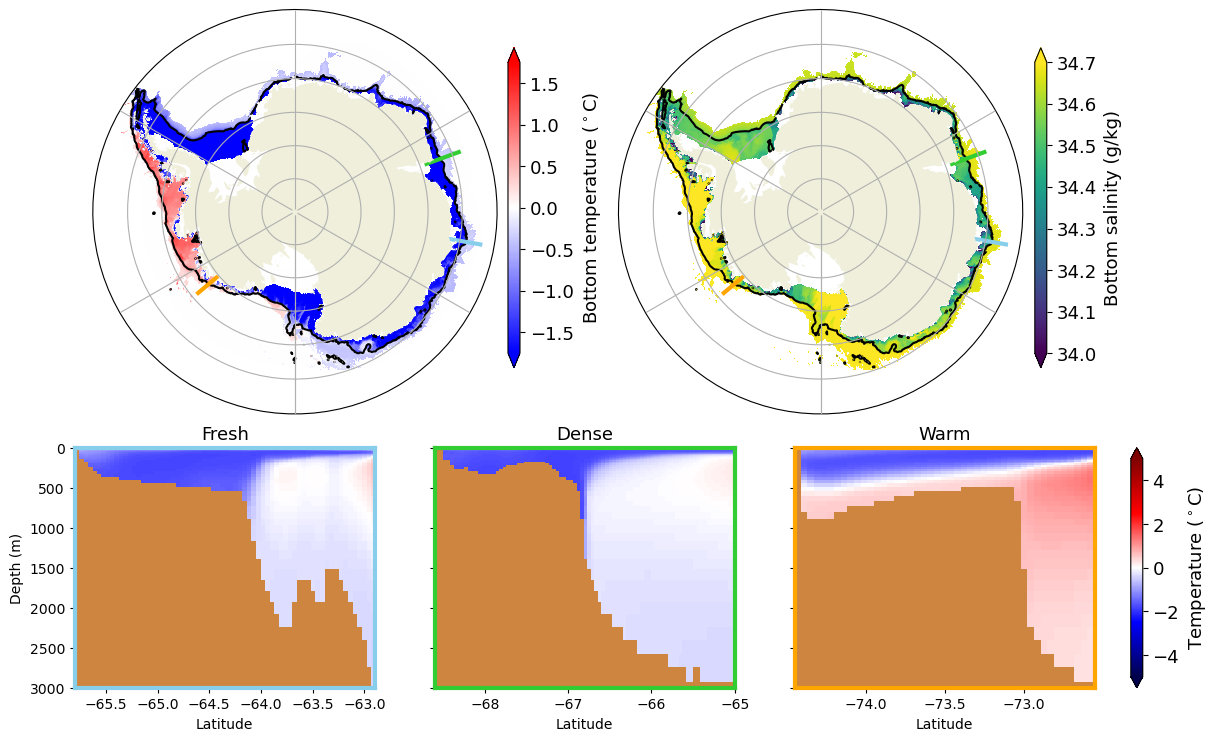

In [13]:
plateCr = ccrs.SouthPolarStereo()
plateCr._threshold = plateCr._threshold/100.  #set finer threshold

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15*0.8,10*0.8), subplot_kw={'projection': plateCr})
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.5, wspace=0.3)
axs[0].set_boundary(circle, transform=axs[0].transAxes)
axs[1].set_boundary(circle, transform=axs[1].transAxes)

axs[0].set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
axs[1].set_extent([-180, 180, -90, -60], ccrs.PlateCarree())

t1 = (bottom_temp_con_both*mask_tot).plot(ax=axs[0], vmin=-1.75, vmax=1.75, cmap=plt.cm.bwr, transform=ccrs.PlateCarree(), add_colorbar=False)
t2 = (bottom_salt_con_both_nan*mask_tot).plot(ax=axs[1], cmap=plt.cm.viridis, vmin=34, vmax=34.7, transform=ccrs.PlateCarree(), add_colorbar=False)

contour1 = (ht*mask_tot).plot.contour(ax=axs[0], levels=[depth_max], colors=['black'], linewidth=0.01, transform=ccrs.PlateCarree())
contour2 = (ht*mask_tot).plot.contour(ax=axs[1], levels=[depth_max], colors=['black'], linewidth=0.01, transform=ccrs.PlateCarree())

axs[0].plot([lon_slice_fresh,lon_slice_fresh],[-70,-62], color='skyblue', transform=ccrs.PlateCarree(), linewidth=3)
axs[1].plot([lon_slice_fresh,lon_slice_fresh],[-70,-62], color='skyblue', transform=ccrs.PlateCarree(), linewidth=3)
axs[0].plot([lon_slice_warm,lon_slice_warm],[-80,-71], color='orange', transform=ccrs.PlateCarree(), linewidth=3)
axs[1].plot([lon_slice_warm,lon_slice_warm],[-80,-71], color='orange', transform=ccrs.PlateCarree(), linewidth=3)
axs[0].plot([lon_slice_dense,lon_slice_dense],[-69,-64], color='limegreen', transform=ccrs.PlateCarree(), linewidth=3)
axs[1].plot([lon_slice_dense,lon_slice_dense],[-69,-64], color='limegreen', transform=ccrs.PlateCarree(), linewidth=3)

gl = axs[0].gridlines(draw_labels=False, xlocs=None, ylocs=None, zorder=10001)
gl.n_steps = 90
axs[0].add_feature(cfeature.LAND, zorder=1000)

# axs[1].coastlines();

gl = axs[1].gridlines(draw_labels=False, xlocs=None, ylocs=None, zorder=10001)
gl.n_steps = 90
axs[1].add_feature(cfeature.LAND, zorder=1000)

cbaxes = fig.add_axes([0.471, 0.3, 0.01, 0.4])
cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature ($^\circ$C)',fontsize=13,labelpad=5)
cbar.ax.tick_params(labelsize=13)

cbaxes = fig.add_axes([0.91, 0.3, 0.01, 0.4])
cbar = plt.colorbar(t2, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salinity (g/kg)',fontsize=13,labelpad=5)
cbar.ax.tick_params(labelsize=13)

# Get the colormap associated with the plot
cmap = plt.cm.get_cmap('seismic')

# Set the color of NaN values to brown
cmap.set_bad(color='peru')

ax1 = fig.add_axes([0+0.11, -0.1, 0.25,0.3])
ax2 = fig.add_axes([0.3+0.11, -0.1, 0.25,0.3])
ax3 = fig.add_axes([0.6+0.11, -0.1, 0.25,0.3])

t1 = temp_con_both.temp.sel(xt_ocean=lon_slice_fresh, method='nearest').plot(ax = ax1, vmin=-5, vmax=5, add_colorbar=False, cmap=plt.cm.seismic)
t2 = temp_con_both.temp.sel(xt_ocean=lon_slice_warm, method='nearest').plot(ax = ax3, vmin=-5, vmax=5, add_colorbar=False, cmap=plt.cm.seismic)
t3 = temp_con_both.temp.sel(xt_ocean=lon_slice_dense, method='nearest').plot(ax = ax2, vmin=-5, vmax=5, add_colorbar=False, cmap=plt.cm.seismic)

ax3.set_xlim(-74.45,-72.55)
ax3.set_ylim(3000,0)

ax2.set_xlim(-68.6,-65)
ax2.set_ylim(3000,0)

ax1.set_xlim(-65.8,-62.9)
ax1.set_ylim(3000,0)

ax3.set_title('Warm', fontsize=13)
ax2.set_title('Dense', fontsize=13)
ax1.set_title('Fresh', fontsize=13)

cbaxes = fig.add_axes([0.99, -0.1, 0.01, 0.3])
cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature ($^\circ$C)', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)

ax1.set_ylabel('Depth (m)')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax2.set_yticklabels([])
ax3.set_yticklabels([])

ax1.set_xlabel('Latitude')
ax2.set_xlabel('Latitude')
ax3.set_xlabel('Latitude')

ax1.spines['bottom'].set_color('skyblue')
ax2.spines['bottom'].set_color('limegreen')
ax3.spines['bottom'].set_color('orange')

ax1.spines['top'].set_color('skyblue')
ax2.spines['top'].set_color('limegreen')
ax3.spines['top'].set_color('orange')

ax1.spines['left'].set_color('skyblue')
ax2.spines['left'].set_color('limegreen')
ax3.spines['left'].set_color('orange')

ax1.spines['right'].set_color('skyblue')
ax2.spines['right'].set_color('limegreen')
ax3.spines['right'].set_color('orange')

ax1.spines['bottom'].set_linewidth(3)
ax2.spines['bottom'].set_linewidth(3)
ax3.spines['bottom'].set_linewidth(3)

ax1.spines['top'].set_linewidth(3)
ax2.spines['top'].set_linewidth(3)
ax3.spines['top'].set_linewidth(3)

ax1.spines['left'].set_linewidth(3)
ax2.spines['left'].set_linewidth(3)
ax3.spines['left'].set_linewidth(3)

ax1.spines['right'].set_linewidth(3)
ax2.spines['right'].set_linewidth(3)
ax3.spines['right'].set_linewidth(3)


plt.savefig('/g/data/e14/txs156/Figures/on_vs_off_shelf_defs.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Assume 'temp_con' is your 3D xarray DataArray with dimensions (z, x, y)
z, x, y = temp_con_on.shape
M = x*y

# Stack the 'x' and 'y' dimensions into a new dimension 'M'
dat_2d_temp_on = (temp_con_on*mask_tot).stack(M=('xt_ocean', 'yt_ocean'))
# Save the lat/lon of each data point M for future plotting
data_xy_on = dat_2d_temp_on.M.values
# Swap the order of dimensions so that 'M' is the last dimension
dat_2d_temp_on = dat_2d_temp_on.transpose('st_ocean', 'M')

# Rename the stacked dimension from 'M' to 'data_point'
dat_2d_temp_on = dat_2d_temp_on.rename({'M': 'data_point'})

# Assign coordinate values to the new 'data_point' dimension
dat_2d_temp_on['data_point'] = range(1, M+1)
dat_2d_temp_on = dat_2d_temp_on.drop('geolon_t').drop('geolat_t')
# 'dat_2d' now has dimensions (z, data_point) where data_point ranges from 1 to x*y

# Now save the depth to do a normalisation into terrain following sigma coordinates
depths_temp_on = dat_2d_temp_on.st_ocean
depths_temp_on = depths_temp_on.expand_dims(dim={'data_point':dat_2d_temp_on.data_point.size},axis=1).assign_coords({'data_point':dat_2d_temp_on.data_point})
depths_2d_temp_on = (depths_temp_on*dat_2d_temp_on/dat_2d_temp_on).rename('depth')

# Assume 'temp_con' is your 3D xarray DataArray with dimensions (z, x, y)
z, x, y = temp_con_off.shape
M = x*y

# Stack the 'x' and 'y' dimensions into a new dimension 'M'
dat_2d_temp_off = (temp_con_off*mask_tot).stack(M=('xt_ocean', 'yt_ocean'))
# Save the lat/lon of each data point M for future plotting
data_xy_off = dat_2d_temp_off.M.values

# Swap the order of dimensions so that 'M' is the last dimension
dat_2d_temp_off = dat_2d_temp_off.transpose('st_ocean', 'M')

# Rename the stacked dimension from 'M' to 'data_point'
dat_2d_temp_off = dat_2d_temp_off.rename({'M': 'data_point'})

# Assign coordinate values to the new 'data_point' dimension
dat_2d_temp_off['data_point'] = range(1, M+1)
dat_2d_temp_off = dat_2d_temp_off.drop('geolon_t').drop('geolat_t')
# 'dat_2d' now has dimensions (z, data_point) where data_point ranges from 1 to x*y

# Now save the depth to do a normalisation into terrain following sigma coordinates
depths_temp_off = dat_2d_temp_off.st_ocean
depths_temp_off = depths_temp_off.expand_dims(dim={'data_point':dat_2d_temp_off.data_point.size},axis=1).assign_coords({'data_point':dat_2d_temp_off.data_point})
depths_2d_temp_off = (depths_temp_off*dat_2d_temp_off/dat_2d_temp_off).rename('depth')

In [15]:
# Assume 'temp_con' is your 3D xarray DataArray with dimensions (z, x, y)
z, x, y = salt_con_on.shape
M = x*y

# Stack the 'x' and 'y' dimensions into a new dimension 'M'
dat_2d_salt_on = (salt_con_on*mask_tot).stack(M=('xt_ocean', 'yt_ocean'))
# Swap the order of dimensions so that 'M' is the last dimension
dat_2d_salt_on = dat_2d_salt_on.transpose('st_ocean', 'M')

# Rename the stacked dimension from 'M' to 'data_point'
dat_2d_salt_on = dat_2d_salt_on.rename({'M': 'data_point'})

# Assign coordinate values to the new 'data_point' dimension
dat_2d_salt_on['data_point'] = range(1, M+1)
dat_2d_salt_on = dat_2d_salt_on.drop('geolon_t').drop('geolat_t')

# Now save the depth to do a normalisation into terrain following sigma coordinates
depths_salt_on = dat_2d_salt_on.st_ocean
depths_salt_on = depths_salt_on.expand_dims(dim={'data_point':dat_2d_salt_on.data_point.size},axis=1).assign_coords({'data_point':dat_2d_salt_on.data_point})
depths_2d_salt_on = (depths_salt_on*dat_2d_salt_on/dat_2d_salt_on).rename('depth')

# Assume 'temp_con' is your 3D xarray DataArray with dimensions (z, x, y)
z, x, y = salt_con_off.shape
M = x*y

# Stack the 'x' and 'y' dimensions into a new dimension 'M'
dat_2d_salt_off = (salt_con_off*mask_tot).stack(M=('xt_ocean', 'yt_ocean'))
# Swap the order of dimensions so that 'M' is the last dimension
dat_2d_salt_off = dat_2d_salt_off.transpose('st_ocean', 'M')

# Rename the stacked dimension from 'M' to 'data_point'
dat_2d_salt_off = dat_2d_salt_off.rename({'M': 'data_point'})

# Assign coordinate values to the new 'data_point' dimension
dat_2d_salt_off['data_point'] = range(1, M+1)
dat_2d_salt_off = dat_2d_salt_off.drop('geolon_t').drop('geolat_t')

# Now save the depth to do a normalisation into terrain following sigma coordinates
depths_salt_off = dat_2d_salt_off.st_ocean
depths_salt_off = depths_salt_off.expand_dims(dim={'data_point':dat_2d_salt_off.data_point.size},axis=1).assign_coords({'data_point':dat_2d_salt_off.data_point})
depths_2d_salt_off = (depths_salt_off*dat_2d_salt_off/dat_2d_salt_off).rename('depth')

In [16]:
# Save the surface area of each data point M for future averaging
data_area_on = (area_t_on*mask_tot).stack(M=('xt_ocean', 'yt_ocean'))
data_area_on = data_area_on.rename({'M': 'data_point'}).rename('area_t').drop('geolon_t').drop('geolat_t').drop('st_ocean')
# Assign coordinate values to the new 'data_point' dimension
data_area_on['data_point'] = range(1, M+1)

# Save the surface area of each data point M for future averaging
data_area_off = (area_t_off*mask_tot).stack(M=('xt_ocean', 'yt_ocean'))
data_area_off = data_area_off.rename({'M': 'data_point'}).rename('area_t').drop('geolon_t').drop('geolat_t').drop('st_ocean')
# Assign coordinate values to the new 'data_point' dimension
data_area_off['data_point'] = range(1, M+1)

data_masked_area_on = data_area_on.to_dataframe()
data_masked_area_off = data_area_off.to_dataframe()

data_masked_area_on = data_masked_area_on.dropna(how='all')
data_masked_area_off = data_masked_area_off.dropna(how='all')

In [17]:
data_masked_area_on

,area_t
data_point,
312,19587724.0
313,19623410.0
314,19659084.0
315,19694750.0
316,19730404.0
...,...
1835843,21041898.0
1835844,21077130.0
1835845,21112352.0


In [18]:
%%time
data_masked_temp_on = dat_2d_temp_on.to_dataframe()
data_masked_salt_on = dat_2d_salt_on.to_dataframe()
depths_masked_temp_on = depths_2d_temp_on.to_dataframe()
depths_masked_salt_on = depths_2d_salt_on.to_dataframe()

data_masked_temp_off = dat_2d_temp_off.to_dataframe()
data_masked_salt_off = dat_2d_salt_off.to_dataframe()
depths_masked_temp_off = depths_2d_temp_off.to_dataframe()
depths_masked_salt_off = depths_2d_salt_off.to_dataframe()

# Calculate the values of M and O
n_rows = data_masked_temp_on.shape[0]
o_cols = dat_2d_temp_on.data_point.size
m_rows = n_rows // o_cols

# Reshape the DataFrame to an MxO shape
reshaped_data_masked_temp_on = pd.DataFrame(np.array(data_masked_temp_on).reshape(m_rows, o_cols), index=dat_2d_temp_on.st_ocean, columns=dat_2d_temp_on.data_point)
reshaped_depths_masked_temp_on = pd.DataFrame(np.array(depths_masked_temp_on).reshape(m_rows, o_cols), index=depths_2d_temp_on.st_ocean, columns=depths_2d_temp_on.data_point)

# Calculate the values of M and O
n_rows = data_masked_salt_on.shape[0]
o_cols = dat_2d_salt_on.data_point.size
m_rows = n_rows // o_cols

# Reshape the DataFrame to an MxO shape
reshaped_data_masked_salt_on = pd.DataFrame(np.array(data_masked_salt_on).reshape(m_rows, o_cols), index=dat_2d_salt_on.st_ocean, columns=dat_2d_salt_on.data_point)
reshaped_depths_masked_salt_on = pd.DataFrame(np.array(depths_masked_salt_on).reshape(m_rows, o_cols), index=depths_2d_salt_on.st_ocean, columns=depths_2d_salt_on.data_point)

# Calculate the values of M and O
n_rows = data_masked_temp_off.shape[0]
o_cols = dat_2d_temp_off.data_point.size
m_rows = n_rows // o_cols

# Reshape the DataFrame to an MxO shape
reshaped_data_masked_temp_off = pd.DataFrame(np.array(data_masked_temp_off).reshape(m_rows, o_cols), index=dat_2d_temp_off.st_ocean, columns=dat_2d_temp_off.data_point)
reshaped_depths_masked_temp_off = pd.DataFrame(np.array(depths_masked_temp_off).reshape(m_rows, o_cols), index=depths_2d_temp_off.st_ocean, columns=depths_2d_temp_off.data_point)

# Calculate the values of M and O
n_rows = data_masked_salt_off.shape[0]
o_cols = dat_2d_salt_off.data_point.size
m_rows = n_rows // o_cols

# Reshape the DataFrame to an MxO shape
reshaped_data_masked_salt_off = pd.DataFrame(np.array(data_masked_salt_off).reshape(m_rows, o_cols), index=dat_2d_salt_off.st_ocean, columns=dat_2d_salt_off.data_point)
reshaped_depths_masked_salt_off = pd.DataFrame(np.array(depths_masked_salt_off).reshape(m_rows, o_cols), index=depths_2d_salt_off.st_ocean, columns=depths_2d_salt_off.data_point)

# Drop locations where all values are NaN (i.e., outside of the margins)

reshaped_data_masked_temp_on = reshaped_data_masked_temp_on.dropna(how='all', axis=1)
reshaped_depths_masked_temp_on = reshaped_depths_masked_temp_on.dropna(how='all', axis=1)
reshaped_data_masked_salt_on = reshaped_data_masked_salt_on.dropna(how='all', axis=1)
reshaped_depths_masked_salt_on = reshaped_depths_masked_salt_on.dropna(how='all', axis=1)
reshaped_data_masked_temp_off = reshaped_data_masked_temp_off.dropna(how='all', axis=1)
reshaped_depths_masked_temp_off = reshaped_depths_masked_temp_off.dropna(how='all', axis=1)
reshaped_data_masked_salt_off = reshaped_data_masked_salt_off.dropna(how='all', axis=1)
reshaped_depths_masked_salt_off = reshaped_depths_masked_salt_off.dropna(how='all', axis=1)

CPU times: user 28.5 s, sys: 22.3 s, total: 50.7 s
Wall time: 1min 3s


In [19]:
reshaped_data_masked_temp_on

,312,313,314,315,316,317,318,319,320,321,...,1835838,1835839,1835840,1835841,1835842,1835843,1835844,1835845,1835846,1835847
0.541281,-1.207443,-1.212499,-1.240522,-1.287270,-1.336999,-1.374943,-1.399071,-1.419855,-1.429365,-1.432831,...,-1.412723,-1.386412,-1.357378,-1.329338,-1.303897,-1.277083,-1.252455,-1.227676,-1.202274,-1.174294
1.680735,-1.204903,-1.210263,-1.238458,-1.285411,-1.335301,-1.373367,-1.397377,-1.417902,-1.427773,-1.431262,...,-1.412423,-1.386118,-1.357078,-1.329100,-1.303525,-1.276653,-1.251949,-1.227280,-1.201980,-1.174160
2.939953,-1.204253,-1.209818,-1.238226,-1.285365,-1.335245,-1.373365,-1.397331,-1.417740,-1.427408,-1.430961,...,-1.412594,-1.386225,-1.357222,-1.329170,-1.303566,-1.276973,-1.252398,-1.227686,-1.202368,-1.174521
4.331521,-1.204381,-1.210078,-1.238796,-1.286288,-1.336172,-1.374024,-1.398010,-1.418422,-1.428018,-1.431554,...,-1.413664,-1.387029,-1.357839,-1.329684,-1.304013,-1.277526,-1.253024,-1.228402,-1.203177,-1.175355
5.869350,-1.205082,-1.210953,-1.240119,-1.288418,-1.338148,-1.375375,-1.399527,-1.419903,-1.429309,-1.433185,...,-1.415602,-1.388616,-1.359287,-1.330867,-1.304893,-1.278476,-1.254155,-1.229728,-1.204587,-1.176794
7.568810,-1.206380,-1.212612,-1.242079,-1.291617,-1.340893,-1.377017,-1.402223,-1.422496,-1.432356,-1.436657,...,-1.420203,-1.393142,-1.363361,-1.334526,-1.308355,-1.282188,-1.257607,-1.232716,-1.207409,-1.179321
9.446885,-1.207912,-1.214986,-1.245894,-1.296997,-1.345461,-1.380605,-1.406364,-1.427529,-1.438167,-1.443042,...,-1.431095,-1.404646,-1.374404,-1.344541,-1.318361,-1.292190,-1.267365,-1.241109,-1.215645,-1.187448
11.522344,-1.209738,-1.218176,-1.252031,-1.304999,-1.354110,-1.388872,-1.414915,-1.437254,-1.448544,-1.454376,...,-1.448770,-1.423310,-1.394401,-1.365222,-1.339131,-1.313179,-1.288636,-1.262971,-1.235732,-1.206780
13.815928,-1.211626,-1.221977,-1.261897,-1.320233,-1.368066,-1.400151,-1.428500,-1.450903,-1.463832,-1.471313,...,-1.464686,-1.439513,-1.410966,-1.384513,-1.363329,-1.343406,-1.321908,-1.298898,-1.275392,-1.252846
16.350553,-1.213510,-1.227150,-1.275503,-1.337103,-1.383802,-1.415177,-1.447725,-1.469326,-1.483106,-1.491715,...,-1.486419,-1.465497,-1.444628,-1.440762,-1.433367,-1.419225,-1.403649,-1.387429,-1.369984,-1.357409


In [17]:
# Normalise all depths to be between 0 and 1 in each column
normalised_depths_temp_on = reshaped_depths_masked_temp_on/reshaped_depths_masked_temp_on.max(skipna=True, axis=0)
normalised_depths_temp_off = reshaped_depths_masked_temp_off/reshaped_depths_masked_temp_off.max(skipna=True, axis=0)
normalised_depths_salt_on = reshaped_depths_masked_salt_on/reshaped_depths_masked_salt_on.max(skipna=True, axis=0)
normalised_depths_salt_off = reshaped_depths_masked_salt_off/reshaped_depths_masked_salt_off.max(skipna=True, axis=0)

depth_bins = depths_temp_off.isel(data_point=0).where(depths_temp_off.isel(data_point=0)<depth_max)/depths_temp_off.isel(data_point=0).where(depths_temp_off.isel(data_point=0)<depth_max).max()
depth_bins = depth_bins.dropna(dim='st_ocean')

In [18]:
%%time
## Interpolate onto a uniform [0,1] sigma co-ordinate for all profiles
import scipy.interpolate as interpolate

new_temp_on = np.zeros((depth_bins.size, normalised_depths_temp_on.keys().size)) 
new_salt_on = np.zeros((depth_bins.size, normalised_depths_salt_on.keys().size)) 
new_temp_off = np.zeros((depth_bins.size, normalised_depths_temp_off.keys().size)) 
new_salt_off = np.zeros((depth_bins.size, normalised_depths_salt_off.keys().size)) 

for i in tqdm(range(normalised_depths_temp_on.keys().size)):
        f_values_temp_on = interpolate.interp1d(normalised_depths_temp_on[normalised_depths_temp_on.keys()[i]].values, reshaped_data_masked_temp_on[normalised_depths_temp_on.keys()[i]].values, fill_value='extrapolate')
        f_values_salt_on = interpolate.interp1d(normalised_depths_salt_on[normalised_depths_salt_on.keys()[i]].values, reshaped_data_masked_salt_on[normalised_depths_salt_on.keys()[i]].values, fill_value='extrapolate')

        new_temp_on[:,i] = f_values_temp_on(depth_bins)
        new_salt_on[:,i] = f_values_salt_on(depth_bins)
        
for i in tqdm(range(normalised_depths_temp_off.keys().size)):
        f_values_temp_off = interpolate.interp1d(normalised_depths_temp_off[normalised_depths_temp_off.keys()[i]].values, reshaped_data_masked_temp_off[normalised_depths_temp_off.keys()[i]].values, fill_value='extrapolate')
        f_values_salt_off = interpolate.interp1d(normalised_depths_salt_off[normalised_depths_salt_off.keys()[i]].values, reshaped_data_masked_salt_off[normalised_depths_salt_off.keys()[i]].values, fill_value='extrapolate')

        new_temp_off[:,i] = f_values_temp_off(depth_bins)
        new_salt_off[:,i] = f_values_salt_off(depth_bins)

# Define the dataframe that will be fed into the GMM, K-means and Heirarchical clustering algorithms
new_T_df_on = pd.DataFrame(new_temp_on, index=depth_bins, columns=normalised_depths_temp_on.keys())
new_S_df_on = pd.DataFrame(new_salt_on, index=depth_bins, columns=normalised_depths_salt_on.keys())

# Define the dataframe that will be fed into the GMM, K-means and Heirarchical clustering algorithms
new_T_df_off = pd.DataFrame(new_temp_off, index=depth_bins, columns=normalised_depths_temp_off.keys())
new_S_df_off = pd.DataFrame(new_salt_off, index=depth_bins, columns=normalised_depths_salt_off.keys())

# Concatenate the T and S profiles and divide by std(tracer)
frames_on = [new_T_df_on/(new_T_df_on.stack().std()), new_S_df_on/(new_S_df_on.stack().std())]
frames_off = [new_T_df_off/(new_T_df_off.stack().std()), new_S_df_off/(new_S_df_off.stack().std())]

result_on = pd.concat(frames_on)
result_off = pd.concat(frames_off)

100%|██████████| 92882/92882 [00:52<00:00, 1752.70it/s]


CPU times: user 2min 34s, sys: 27.2 s, total: 3min 2s
Wall time: 2min 32s


In [19]:
# define the number of columns to add
M = depth_bins.size
# repeat the first column M times and concatenate the result
data_masked_area_on_2d = pd.concat([data_masked_area_on] * M, axis=1)
data_masked_area_off_2d = pd.concat([data_masked_area_off] * M, axis=1)

# assign column names to the new DataFrame
data_masked_area_on_2d.columns = [depth_bins.values[i] for i in range(M)]
data_masked_area_on_2d = data_masked_area_on_2d.T
data_masked_area_off_2d.columns = [depth_bins.values[i] for i in range(M)]
data_masked_area_off_2d = data_masked_area_off_2d.T

In [20]:
reformed_area_on = np.nan*np.ones((data_masked_area_on_2d.shape[0], data_xy_on.shape[0]))
reformed_temp_on = np.nan*np.ones_like(reformed_area_on)
reformed_salt_on = np.nan*np.ones_like(reformed_area_on)

for i in tqdm(range(data_masked_area_on.index.size)):
    reformed_area_on[:,data_masked_area_on.index[i]-1] = data_masked_area_on_2d.values[:,i]
    reformed_temp_on[:,data_masked_area_on.index[i]-1] = new_temp_on[:,i]
    reformed_salt_on[:,data_masked_area_on.index[i]-1] = new_salt_on[:,i]
    
reshaped_area_on = reformed_area_on.reshape(data_masked_area_on_2d.shape[0], y,x)
reshaped_temp_on = reformed_temp_on.reshape(data_masked_area_on_2d.shape[0], y,x)
reshaped_salt_on = reformed_salt_on.reshape(data_masked_area_on_2d.shape[0], y,x)

data_masked_area_on_da = xr.DataArray(reshaped_area_on, dims=('depth', 'longitude', 'latitude'), coords={'depth': ('depth', depth_bins.values), 'latitude': ('latitude', salt_con_on.yt_ocean.values), 'longitude': ('longitude', salt_con_on.xt_ocean.values)})
data_masked_temp_on_da = xr.DataArray(reshaped_temp_on, dims=('depth', 'longitude', 'latitude'), coords={'depth': ('depth', depth_bins.values), 'latitude': ('latitude', salt_con_on.yt_ocean.values), 'longitude': ('longitude', salt_con_on.xt_ocean.values)})
data_masked_salt_on_da = xr.DataArray(reshaped_salt_on, dims=('depth', 'longitude', 'latitude'), coords={'depth': ('depth', depth_bins.values), 'latitude': ('latitude', salt_con_on.yt_ocean.values), 'longitude': ('longitude', salt_con_on.xt_ocean.values)})


reformed_area_off = np.nan*np.ones((data_masked_area_off_2d.shape[0], data_xy_off.shape[0]))
reformed_temp_off = np.nan*np.ones_like(reformed_area_off)
reformed_salt_off = np.nan*np.ones_like(reformed_area_off)

for i in tqdm(range(data_masked_area_off.index.size)):
    reformed_area_off[:,data_masked_area_off.index[i]-1] = data_masked_area_off_2d.values[:,i]
    reformed_temp_off[:,data_masked_area_off.index[i]-1] = new_temp_off[:,i]
    reformed_salt_off[:,data_masked_area_off.index[i]-1] = new_salt_off[:,i]
    
reshaped_area_off = reformed_area_off.reshape(data_masked_area_off_2d.shape[0], y,x)
reshaped_temp_off = reformed_temp_off.reshape(data_masked_area_off_2d.shape[0], y,x)
reshaped_salt_off = reformed_salt_off.reshape(data_masked_area_off_2d.shape[0], y,x)

data_masked_area_off_da = xr.DataArray(reshaped_area_off, dims=('depth', 'longitude', 'latitude'), coords={'depth': ('depth', depth_bins.values), 'latitude': ('latitude', salt_con_off.yt_ocean.values), 'longitude': ('longitude', salt_con_off.xt_ocean.values)})
data_masked_temp_off_da = xr.DataArray(reshaped_temp_off, dims=('depth', 'longitude', 'latitude'), coords={'depth': ('depth', depth_bins.values), 'latitude': ('latitude', salt_con_off.yt_ocean.values), 'longitude': ('longitude', salt_con_off.xt_ocean.values)})
data_masked_salt_off_da = xr.DataArray(reshaped_salt_off, dims=('depth', 'longitude', 'latitude'), coords={'depth': ('depth', depth_bins.values), 'latitude': ('latitude', salt_con_off.yt_ocean.values), 'longitude': ('longitude', salt_con_off.xt_ocean.values)})


100%|██████████| 92882/92882 [00:00<00:00, 107333.98it/s]


In [21]:
# Get the colormap associated with the plot
cmap = plt.cm.get_cmap('bwr')

# Set the color of NaN values to brown
cmap.set_bad(color='peru')
cmap = plt.cm.get_cmap('viridis')

# Set the color of NaN values to brown
cmap.set_bad(color='peru')


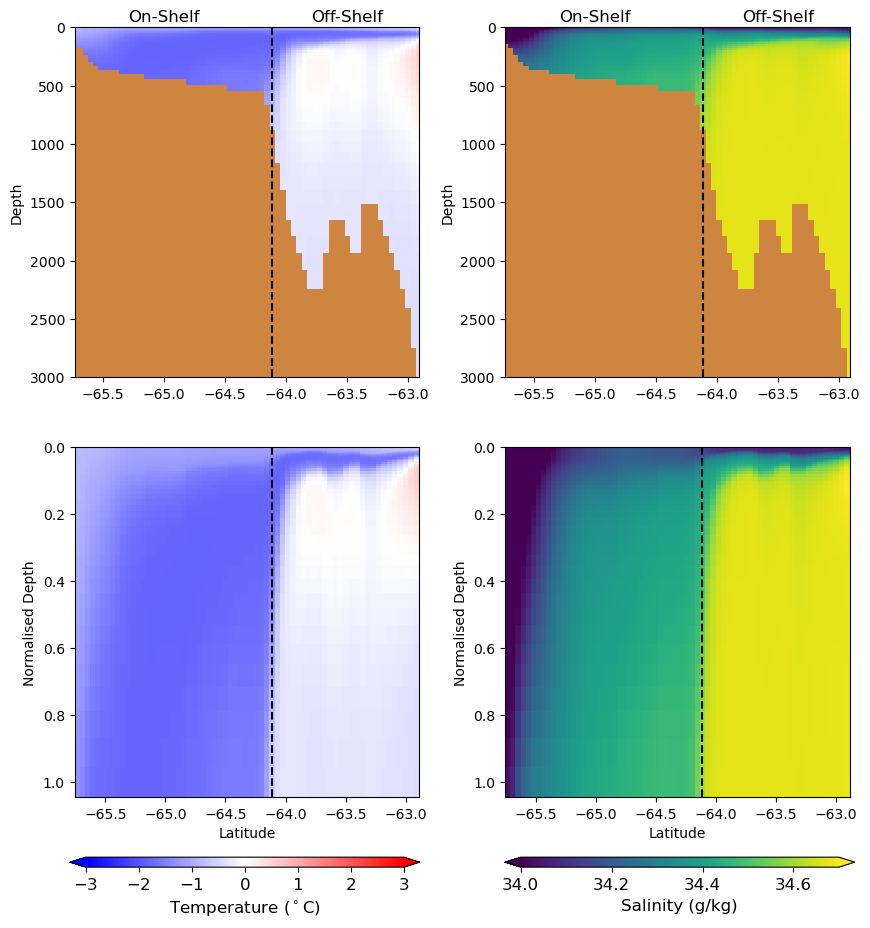

In [23]:
min_lat_both = xr.where(np.isnan(data_masked_temp_off_da), data_masked_temp_on_da, data_masked_temp_off_da).sel(longitude=lon_slice, method='nearest').dropna('latitude').latitude.min().values
max_lat_both = xr.where(np.isnan(data_masked_temp_off_da), data_masked_temp_on_da, data_masked_temp_off_da).sel(longitude=lon_slice, method='nearest').dropna('latitude').latitude.max().values
max_lat_on = data_masked_temp_on_da.sel(longitude=lon_slice, method='nearest').dropna('latitude').latitude.max().values

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.25)

xr.where(np.isnan(data_masked_salt_off_da), data_masked_salt_on_da, data_masked_salt_off_da).sel(longitude=lon_slice, method='nearest').dropna('latitude').plot(ax=axs[3], vmin=34, vmax=34.7, add_colorbar=False)
xr.where(np.isnan(data_masked_temp_off_da), data_masked_temp_on_da, data_masked_temp_off_da).sel(longitude=lon_slice, method='nearest').dropna('latitude').plot(ax=axs[2], vmin=-3, vmax=3, add_colorbar=False, cmap=plt.cm.bwr)
t1 = temp_con_both.temp.sel(xt_ocean=lon_slice, method='nearest').plot(ax = axs[0], vmin=-3, vmax=3, add_colorbar=False, cmap=plt.cm.bwr)
t2 = salt_con_both.salt.sel(xt_ocean=lon_slice, method='nearest').plot(ax = axs[1], vmin=34, vmax=34.7, add_colorbar=False)

for i in range(4):
    axs[i].plot([max_lat_on,max_lat_on],[0,3000], '--k')
    axs[i].invert_yaxis()
    axs[i].set_title('')
    if i>=2:
        axs[i].set_ylabel('Normalised Depth')
        axs[i].set_xlabel('Latitude')
        # axs[i].text(-65,-0.01, 'On-Shelf', ha='center', fontsize=12)
        # axs[i].text(-63.5,-0.01, 'Off-Shelf', ha='center', fontsize=12)
    else:
        axs[i].set_ylim(3000,0)
        axs[i].set_ylabel('Depth')
        axs[i].set_xlim(min_lat_both, max_lat_both)
        axs[i].text(-65,-50, 'On-Shelf', ha='center', fontsize=12)
        axs[i].text(-63.5,-50, 'Off-Shelf', ha='center', fontsize=12)
        axs[i].set_xlabel('')

cbaxes = fig.add_axes([0.12, 0.04, 0.35, 0.01])
cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=12,labelpad=5)
cbar.ax.tick_params(labelsize=12)

cbaxes = fig.add_axes([0.555, 0.04, 0.35, 0.01])
cbar = plt.colorbar(t2, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Salinity (g/kg)',fontsize=12,labelpad=5)
cbar.ax.tick_params(labelsize=12)
        
plt.savefig('/g/data/e14/txs156/Figures/sigma_transform.png', dpi=300, bbox_inches='tight')        
plt.show()


In [24]:
mean_salt_off_lon = (data_masked_salt_off_da*data_masked_area_off_da).sum('latitude')/(data_masked_area_off_da).sum('latitude')
mean_salt_on_lon = (data_masked_salt_on_da*data_masked_area_on_da).sum('latitude')/(data_masked_area_on_da).sum('latitude')
mean_temp_off_lon = (data_masked_temp_off_da*data_masked_area_off_da).sum('latitude')/(data_masked_area_off_da).sum('latitude')
mean_temp_on_lon = (data_masked_temp_on_da*data_masked_area_on_da).sum('latitude')/(data_masked_area_on_da).sum('latitude')

In [25]:
# Calculate the values of M and O
n_rows = mean_salt_off_lon.shape[0]
o_cols = mean_salt_off_lon.longitude.size

# Reshape the DataFrame to an MxO shape
reshaped_mean_salt_off_lon = pd.DataFrame(np.array(mean_salt_off_lon).reshape(n_rows, o_cols), index=mean_salt_off_lon.depth, columns=mean_salt_off_lon.longitude)
reshaped_mean_salt_on_lon = pd.DataFrame(np.array(mean_salt_on_lon).reshape(n_rows, o_cols), index=mean_salt_on_lon.depth, columns=mean_salt_on_lon.longitude)
reshaped_mean_temp_off_lon = pd.DataFrame(np.array(mean_temp_off_lon).reshape(n_rows, o_cols), index=mean_temp_off_lon.depth, columns=mean_temp_off_lon.longitude)
reshaped_mean_temp_on_lon = pd.DataFrame(np.array(mean_temp_on_lon).reshape(n_rows, o_cols), index=mean_temp_on_lon.depth, columns=mean_temp_on_lon.longitude)

# create a boolean mask indicating which columns in df1 have NaN values
mask = reshaped_mean_salt_on_lon.isna().all()

# select the corresponding columns in df2 to be dropped
columns_to_drop = reshaped_mean_salt_off_lon.columns[mask]

# drop the columns from df2
reshaped_mean_salt_off_lon_masked = reshaped_mean_salt_off_lon.drop(columns_to_drop, axis=1)

# create a boolean mask indicating which columns in df1 have NaN values
mask = reshaped_mean_temp_on_lon.isna().all()

# select the corresponding columns in df2 to be dropped
columns_to_drop = reshaped_mean_temp_off_lon.columns[mask]

# drop the columns from df2
reshaped_mean_temp_off_lon_masked = reshaped_mean_temp_off_lon.drop(columns_to_drop, axis=1)

reshaped_mean_salt_on_lon_masked = reshaped_mean_salt_on_lon.dropna(how='all', axis=1)
reshaped_mean_temp_on_lon_masked = reshaped_mean_temp_on_lon.dropna(how='all', axis=1)

mean_frames = [reshaped_mean_temp_on_lon_masked/(reshaped_mean_temp_on_lon_masked.stack().std()), reshaped_mean_temp_off_lon_masked/(reshaped_mean_temp_off_lon_masked.stack().std()),\
                 reshaped_mean_salt_on_lon_masked/(reshaped_mean_salt_on_lon_masked.stack().std()), reshaped_mean_salt_off_lon_masked/(reshaped_mean_salt_off_lon_masked.stack().std())]
mean_result = pd.concat(mean_frames)

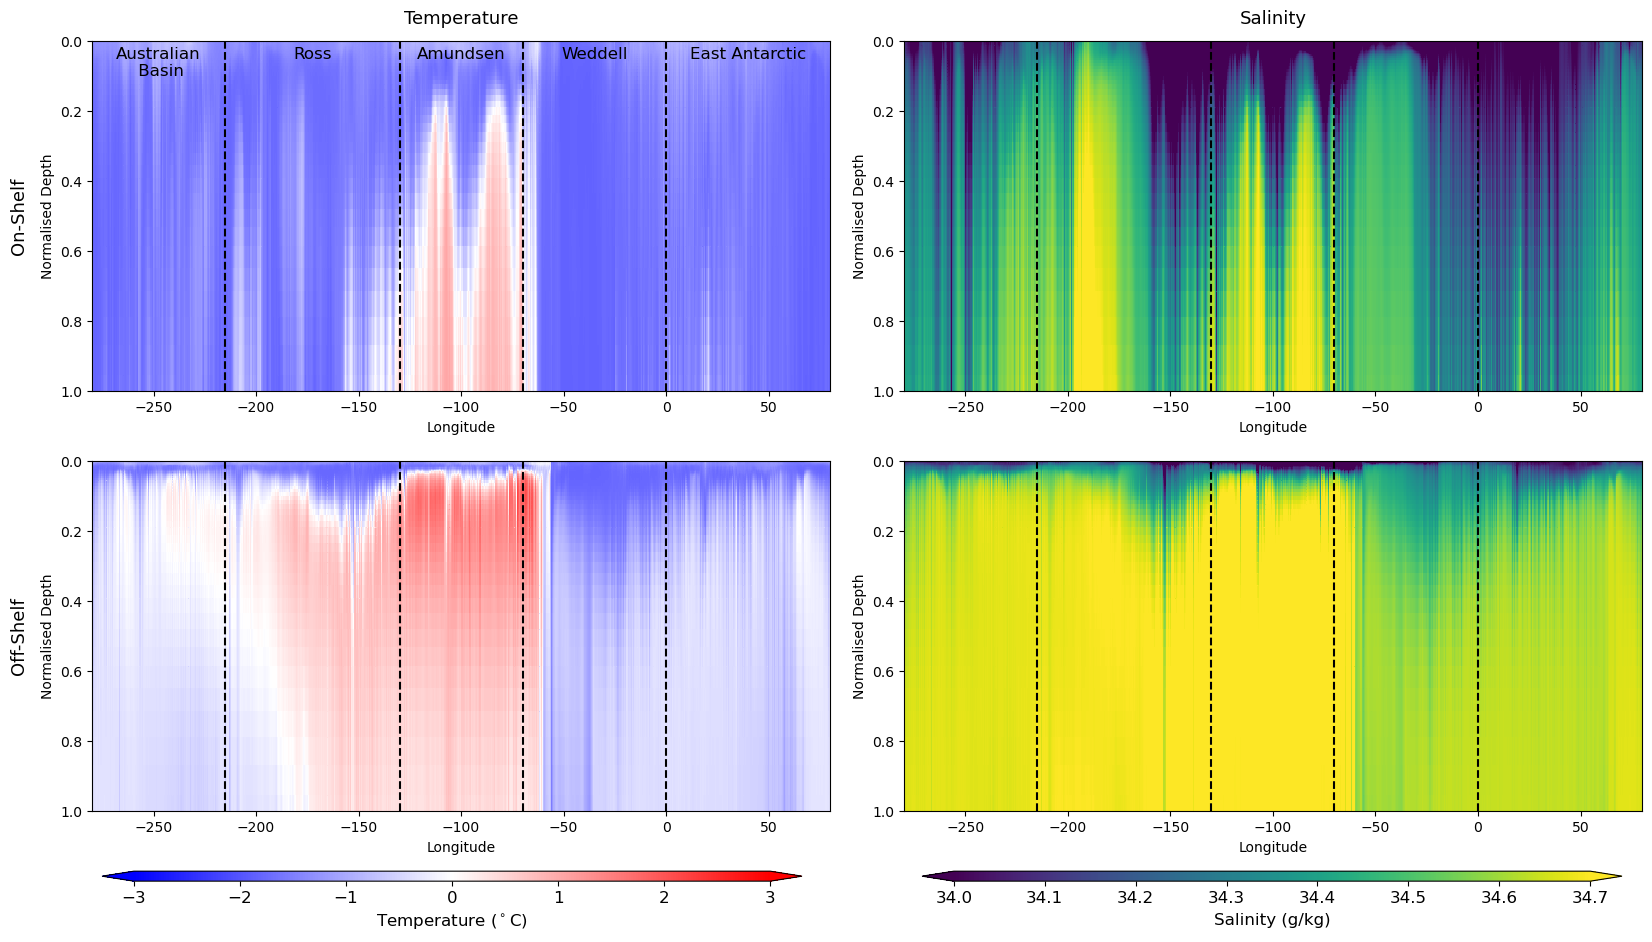

In [26]:
Basins = np.array(['Ross Sector','Weddell Sector','Australian Antarctic Sector','East Antarctic Sector','Amundsen Sector'])

lon_slice = np.array([slice(-215,-130),slice(-70,0),slice(-280,-215),slice(0,80),slice(-130,-70)])


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.1)


t1 = axs[0].pcolor(reshaped_mean_temp_on_lon_masked.columns, reshaped_mean_temp_on_lon_masked.index, reshaped_mean_temp_on_lon_masked, vmin=-3, vmax=3, cmap=plt.cm.bwr)
axs[2].pcolor(reshaped_mean_temp_off_lon_masked.columns, reshaped_mean_temp_off_lon_masked.index, reshaped_mean_temp_off_lon_masked, vmin=-3, vmax=3, cmap=plt.cm.bwr)
t2 = axs[1].pcolor(reshaped_mean_salt_on_lon_masked.columns, reshaped_mean_salt_on_lon_masked.index, reshaped_mean_salt_on_lon_masked, vmin=34, vmax=34.7, cmap=plt.cm.viridis)
axs[3].pcolor(reshaped_mean_salt_off_lon_masked.columns, reshaped_mean_salt_off_lon_masked.index, reshaped_mean_salt_off_lon_masked, vmin=34, vmax=34.7, cmap=plt.cm.viridis)

for i in range(4):
    axs[i].invert_yaxis()
    axs[i].set_ylim(reshaped_mean_salt_off_lon_masked.index.max(), 0)
    axs[i].set_ylabel('Normalised Depth')
    axs[i].set_xlabel('Longitude')

    axs[i].plot([-215,-215], [0,1.2], '--k')
    axs[i].plot([-130,-130], [0,1.2], '--k')
    axs[i].plot([-70,-70], [0,1.2], '--k')
    axs[i].plot([0,0], [0,1.2], '--k')
    
axs[0].text(40,0.05,'East Antarctic', ha='center', fontsize=12)
axs[0].text(-35,0.05,'Weddell', ha='center', fontsize=12)
axs[0].text(-100,0.05,'Amundsen', ha='center', fontsize=12)
axs[0].text(-172.5,0.05,'Ross', ha='center', fontsize=12)
axs[0].text(-247.5,0.1,'Australian\n Basin', ha='center', fontsize=12)
axs[0].text(-320,0.5,'On-Shelf', rotation=90, va='center', fontsize=13)
axs[2].text(-320,0.5,'Off-Shelf', rotation=90, va='center', fontsize=13)
axs[0].text(-100,-0.05,'Temperature', ha='center', fontsize=13)
axs[1].text(-100,-0.05,'Salinity', ha='center', fontsize=13)

cbaxes = fig.add_axes([0.13, 0.04, 0.35, 0.01])
cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Temperature ($^\circ$C)',fontsize=12,labelpad=5)
cbar.ax.tick_params(labelsize=12)

cbaxes = fig.add_axes([0.54, 0.04, 0.35, 0.01])
cbar = plt.colorbar(t2, cax = cbaxes, orientation = 'horizontal',extend = 'both')
cbar.set_label(r'Salinity (g/kg)',fontsize=12,labelpad=5)
cbar.ax.tick_params(labelsize=12)

plt.savefig('/g/data/e14/txs156/Figures/on_vs_off_avg_profiles.png', dpi=300, bbox_inches='tight')        

plt.show()
# reshaped_mean_temp_off_lon_masked
# reshaped_mean_salt_on_lon_masked
# reshaped_mean_salt_off_lon_masked

In [76]:
# %%time
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, davies_bouldin_score

n_clusters = []
labels_gmm = []
centers_gmm = []
probs_gmm = []

aic_gmm = []
bic_gmm = []
silhouette_gmm = []

X = mean_result.T

k_clusters = range(1,22)
for k in tqdm(k_clusters):
    n_clusters.append(k)
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels_gmm.append(gmm.fit_predict(X))
    centers_gmm.append(gmm.means_)
    probs_gmm.append(gmm.predict_proba(X))
    aic_gmm.append(gmm.aic(X))
    bic_gmm.append(gmm.bic(X))
    if k>=3:
        silhouette_gmm.append(silhouette_score(X, labels_gmm[k-2], metric='euclidean'))

#     # Calculate AIC and BIC
#     likelihood = gmm.score(X)
#     n_samples, n_features = X.shape
#     aic_test = k * 2 - 2 * likelihood
#     bic_test = k * np.log(n_features) - 2 * likelihood

#     aic_scores_test.append(aic_test)
#     bic_scores_test.append(bic_test)
#     # Calculate AIC and BIC scores for GMM
#     aic_scores_gmm.append(gmm.aic(X))
#     bic_scores_gmm.append(gmm.bic(X))labels_mean = kmeans_mean.fit_predict(mean_result.T)
# centers_mean = kmeans_mean.cluster_centers_

100%|██████████| 21/21 [01:13<00:00,  3.52s/it]


In [211]:
print(centers_gmm[2].shape)

(3, 184)


In [195]:
print(np.argmin(bic_gmm))

2


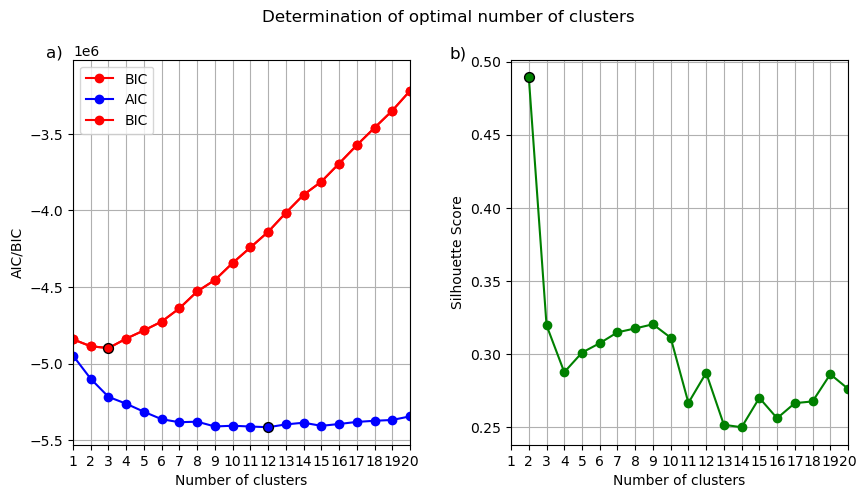

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.3, wspace=0.3)

axs[0].plot(n_clusters, bic_gmm, 'r-o', label='BIC')
axs[0].plot(n_clusters, aic_gmm, 'b-o', label='AIC')
axs[0].plot(n_clusters, bic_gmm, 'r-o', label='BIC')
axs[0].scatter(n_clusters[np.argmin(aic_gmm)], aic_gmm[np.argmin(aic_gmm)], 50, color='blue', ec='k', zorder=10000)
axs[0].scatter(n_clusters[np.argmin(bic_gmm)], bic_gmm[np.argmin(bic_gmm)], 50, color='red', ec='k', zorder=10000)

axs[0].set_xticks(n_clusters)
axs[0].legend()
axs[0].set_xlabel('Number of clusters')
axs[0].set_xlim(1,20)
axs[0].grid()
axs[0].set_ylabel('AIC/BIC')
axs[0].legend()


axs[1].plot(n_clusters[1:-1], silhouette_gmm, '-go', label='Silhouette Score')
axs[1].scatter(n_clusters[1:-1][np.argmax(silhouette_gmm)], silhouette_gmm[np.argmax(silhouette_gmm)], 50, color='green', ec='k', zorder=10000)

axs[1].set_xlabel('Number of clusters')
axs[1].set_ylabel('Silhouette Score')
axs[1].set_xticks(np.arange(1,21))
axs[1].set_xlim(1,20)
axs[1].grid()

axs[0].text(-0.5,-3e6,'a)', fontsize=12)
axs[1].text(-2.5,0.502,'b)', fontsize=12)

plt.suptitle('Determination of optimal number of clusters', fontsize=12)
plt.savefig('/g/data/e14/txs156/Figures/Scores_GMM_assess.png', dpi=300, bbox_inches='tight')
plt.show()

In [220]:
# Note: Optimal n is 1 less than the actual number of clusters, so n_optimal = 2 implies 3 clusters, etc. 
n_optimal = 2

In [221]:
a = np.array(xv)
b = np.array(pd.Series(reshaped_mean_temp_on_lon_masked.columns))

b_rounded = np.round(b, decimals=2)
a_rounded = np.round(a, decimals=2)

# Create an array of NaN values with the same shape as `a`
labels_nanned = np.full_like(a, np.nan)
matching_indices = np.where(np.isin(a_rounded, b_rounded))[0]


labels_nanned[matching_indices] = labels_gmm[n_optimal]

labels_nanned_2d = np.repeat(labels_nanned[np.newaxis, :], yv.shape, axis=0)


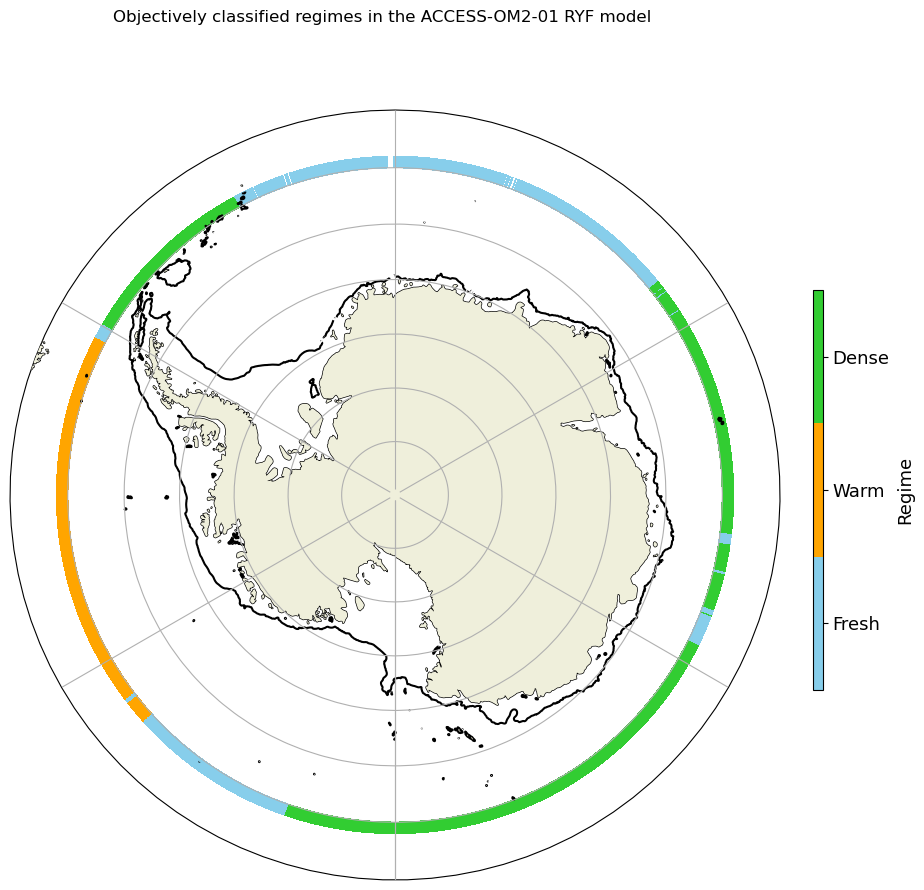

CPU times: user 1min 26s, sys: 6.95 s, total: 1min 33s
Wall time: 1min 25s


In [222]:
%%time

plateCr = ccrs.SouthPolarStereo()
plateCr._threshold = plateCr._threshold/100.  #set finer threshold

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

# Specify colors for specific values
if n_optimal == 2:
    colors = ['skyblue', 'orange', 'limegreen']
    values = [0, 1, 2]
    classes = ['Fresh', 'Warm', 'Dense']
    cmap = plt.cm.colors.ListedColormap(colors)
else:
    cmap = plt.cm.tab10
    
# Create colormap with specified colors for specific values
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,10), subplot_kw={'projection': plateCr})

t1 = axs.pcolor(xv,yv[-20:],labels_nanned_2d[-20:,:], transform=ccrs.PlateCarree(), cmap=cmap)
axs.coastlines();
axs.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())
ht.plot.contour(ax=axs, levels=[depth_max], colors='black', linewidth=0.5, transform=ccrs.PlateCarree())
axs.set_boundary(circle, transform=axs.transAxes)

gl = axs.gridlines(draw_labels=False, xlocs=None, ylocs=None, zorder=10001)
gl.n_steps = 90
axs.add_feature(cfeature.LAND, zorder=1000)

cbaxes = fig.add_axes([0.93, 0.3, 0.01, 0.4])
cbar = plt.colorbar(t1, cax = cbaxes, orientation = 'vertical')
cbar.set_label(r'Regime', fontsize=13, labelpad=5)
cbar.ax.tick_params(labelsize=13)
if n_optimal == 2:
    cbar.ax.set_yticks([1/3,1,5/3])
    cbar.ax.set_yticklabels(classes)

plt.suptitle('Objectively classified regimes in the ACCESS-OM2-01 RYF model')
plt.savefig('/g/data/e14/txs156/Figures/GMM_OM2_01_regimes_map.png', dpi=300, bbox_inches='tight')
plt.show()

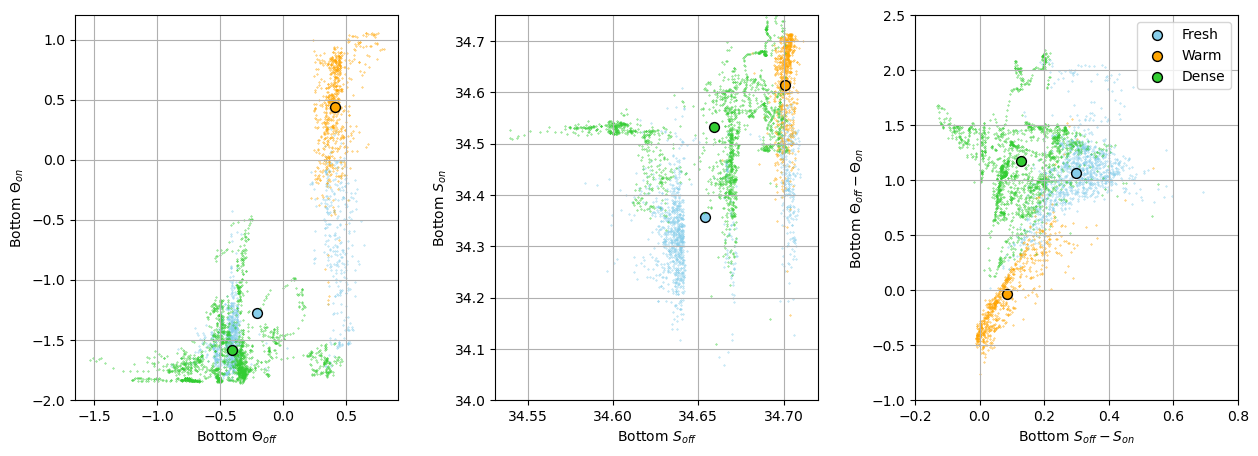

In [223]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.5, wspace=0.3)

for i in range(n_clusters[n_optimal]):
    ind = np.argwhere(labels_gmm[n_optimal]==i)
    axs[0].scatter(reshaped_mean_temp_off_lon_masked.values[-1,ind].flatten(), reshaped_mean_temp_on_lon_masked.values[-1,ind].flatten(), .1, color = colors[i])
    axs[1].scatter(reshaped_mean_salt_off_lon_masked.values[-1,ind].flatten(), reshaped_mean_salt_on_lon_masked.values[-1,ind].flatten(), .1, color = colors[i])
    axs[2].scatter(reshaped_mean_salt_off_lon_masked.values[-1,ind].flatten()-reshaped_mean_salt_on_lon_masked.values[-1,ind].flatten(),\
                   reshaped_mean_temp_off_lon_masked.values[-1,ind].flatten()-reshaped_mean_temp_on_lon_masked.values[-1,ind].flatten(), .1, color = colors[i])

    
    axs[0].scatter(np.nanmean(reshaped_mean_temp_off_lon_masked.values[-1,ind].flatten()), \
                   np.nanmean(reshaped_mean_temp_on_lon_masked.values[-1,ind].flatten()), 
                   50, ec='k', color=colors[i], label = classes[i])
    axs[1].scatter(np.nanmean(reshaped_mean_salt_off_lon_masked.values[-1,ind].flatten()), \
                   np.nanmean(reshaped_mean_salt_on_lon_masked.values[-1,ind].flatten()), \
                   50, ec='k', color=colors[i], label = classes[i])    
    axs[2].scatter(np.nanmean(reshaped_mean_salt_off_lon_masked.values[-1,ind].flatten())\
                   -np.nanmean(reshaped_mean_salt_on_lon_masked.values[-1,ind].flatten()),\
                   np.nanmean(reshaped_mean_temp_off_lon_masked.values[-1,ind].flatten())\
                   -np.nanmean(reshaped_mean_temp_on_lon_masked.values[-1,ind].flatten()), 50, color = colors[i], ec='k', label = classes[i])

axs[0].set_xlabel('Bottom $\Theta_{off}$')
axs[0].set_ylabel('Bottom $\Theta_{on}$')
axs[1].set_xlabel('Bottom $S_{off}$')
axs[1].set_ylabel('Bottom $S_{on}$')
axs[-1].set_xlabel('Bottom $S_{off}-S_{on}$')
axs[-1].set_ylabel('Bottom $\Theta_{off}-\Theta_{on}$')
axs[-1].set_xlim(-0.2,0.8)
axs[-1].set_ylim(-1,2.5)
axs[1].set_ylim(34,34.75)

axs[0].grid()
axs[1].grid()
axs[2].grid()
axs[-1].legend()

plt.savefig('/g/data/e14/txs156/Figures/bottom_temp_clusters_GMM.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 3/3 [00:08<00:00,  2.85s/it]


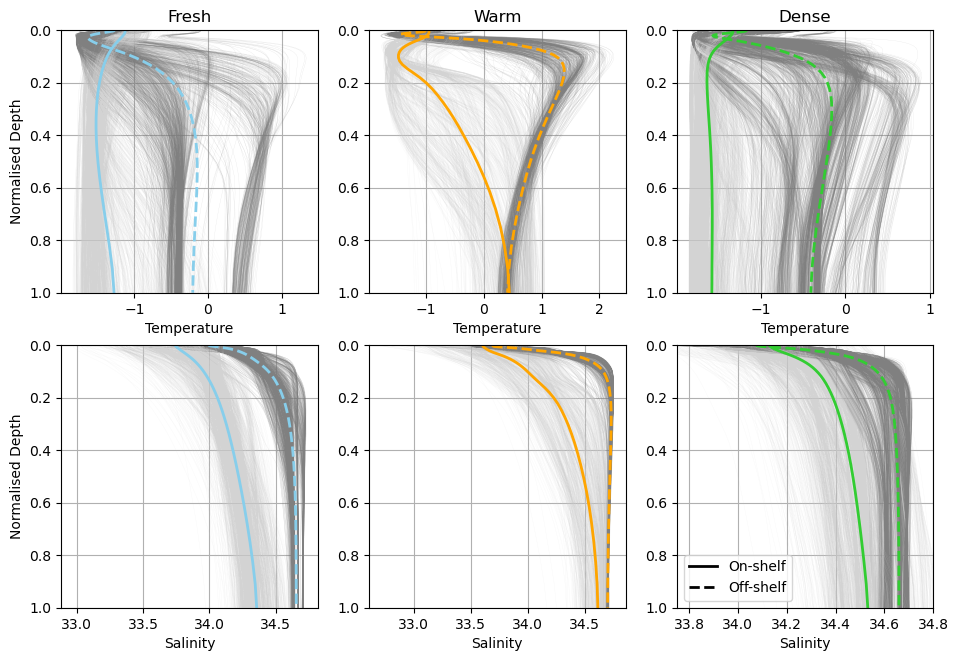

CPU times: user 57.8 s, sys: 11 s, total: 1min 8s
Wall time: 54.7 s


In [228]:
%%time

fig, axs = plt.subplots(nrows=2, ncols=n_clusters[n_optimal], figsize=(7.5*1.5, 5*1.5))
axs = axs.ravel()
plt.subplots_adjust(hspace = 0.2, wspace=0.2)

for i in tqdm(range(n_clusters[n_optimal])):
    ind = np.argwhere(labels_gmm[n_optimal]==i)
    for j in range(ind.size):
        axs[i].plot(reshaped_mean_temp_off_lon_masked.values[:,ind[j]], depth_bins, color='grey', alpha=0.2, linewidth=0.2)
        axs[i].plot(reshaped_mean_temp_on_lon_masked.values[:,ind[j]], depth_bins, color='lightgrey', alpha=0.2, linewidth=0.2)
        axs[i+n_clusters[n_optimal]].plot(reshaped_mean_salt_off_lon_masked.values[:,ind[j]], depth_bins, color='grey', alpha=0.2, linewidth=0.2)
        axs[i+n_clusters[n_optimal]].plot(reshaped_mean_salt_on_lon_masked.values[:,ind[j]], depth_bins, color='lightgrey', alpha=0.2, linewidth=0.2)
    axs[i].plot(centers_gmm[n_optimal][i,:depth_bins.size]*(reshaped_mean_temp_on_lon_masked.stack().std()), depth_bins, color=colors[i], linewidth=2)
    axs[i].plot(centers_gmm[n_optimal][i,depth_bins.size:(depth_bins.size*2)]*(reshaped_mean_temp_off_lon_masked.stack().std()), depth_bins, color=colors[i], linewidth=2, linestyle = 'dashed')
    axs[i+n_clusters[n_optimal]].plot(centers_gmm[n_optimal][i,(depth_bins.size*2):(depth_bins.size*3)]*(reshaped_mean_salt_on_lon_masked.stack().std()), depth_bins, color=colors[i], linewidth=2)
    axs[i+n_clusters[n_optimal]].plot(centers_gmm[n_optimal][i,(depth_bins.size*3):]*(reshaped_mean_salt_off_lon_masked.stack().std()), depth_bins, color=colors[i], linewidth=2, linestyle = 'dashed')
    axs[i].set_title(classes[i])
    axs[i].set_xlabel('Temperature')
    axs[i+n_clusters[n_optimal]].set_xlabel('Salinity')
axs[-1].plot([-1000,-1000], [-1000,-500], color='k', linewidth=2, label='On-shelf')
axs[-1].plot([-1000,-1000], [-1000,-500], color='k', linewidth=2, linestyle='dashed', label='Off-shelf')

for i in range(6):
    axs[i].grid()
    axs[i].set_ylim(0,1)
    axs[i].invert_yaxis()
axs[0].set_ylabel('Normalised Depth')
axs[3].set_ylabel('Normalised Depth')
axs[-1].set_xlim(33.75,34.8)
axs[-1].legend()

plt.savefig('/g/data/e14/txs156/Figures/cluster_profiles_latavg_GMM.png', dpi=300, bbox_inches='tight')
plt.show()

In [230]:
temp_on_lon_da = xr.DataArray(data=reshaped_mean_temp_on_lon_masked.T.values, \
                              dims={'longitude':int(reshaped_mean_temp_on_lon_masked.columns.size), 'sigma':depth_bins.size},\
                              coords = {'longitude':reshaped_mean_temp_on_lon_masked.columns.values, 'sigma':depth_bins.values})
temp_off_lon_da = xr.DataArray(data=reshaped_mean_temp_off_lon_masked.T.values, \
                              dims={'longitude':int(reshaped_mean_temp_on_lon_masked.columns.size), 'sigma':depth_bins.size},\
                              coords = {'longitude':reshaped_mean_temp_on_lon_masked.columns.values, 'sigma':depth_bins.values})
salt_on_lon_da = xr.DataArray(data=reshaped_mean_salt_on_lon_masked.T.values, \
                              dims={'longitude':int(reshaped_mean_temp_on_lon_masked.columns.size), 'sigma':depth_bins.size},\
                              coords = {'longitude':reshaped_mean_temp_on_lon_masked.columns.values, 'sigma':depth_bins.values})
salt_off_lon_da = xr.DataArray(data=reshaped_mean_salt_off_lon_masked.T.values, \
                              dims={'longitude':int(reshaped_mean_temp_on_lon_masked.columns.size), 'sigma':depth_bins.size},\
                              coords = {'longitude':reshaped_mean_temp_on_lon_masked.columns.values, 'sigma':depth_bins.values})
cluster_labels_da = xr.DataArray(data=labels_gmm[n_optimal], \
                              dims={'longitude':int(reshaped_mean_temp_on_lon_masked.columns.size)},\
                              coords = {'longitude':reshaped_mean_temp_on_lon_masked.columns.values})

ds_3_cluster_control = xr.Dataset()

ds_3_cluster_control['temp_on'] = temp_on_lon_da
ds_3_cluster_control['temp_off'] = temp_off_lon_da

ds_3_cluster_control['salt_on'] = salt_on_lon_da
ds_3_cluster_control['salt_off'] = salt_off_lon_da

ds_3_cluster_control['cluster_label'] = cluster_labels_da

ds_3_cluster_control.to_netcdf('/g/data/e14/txs156/Analysis/ACCESS-OM2/processed_netcdf_files/control_cluster3_GMM.nc')
